In [1]:
import json

import pickle
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")

import rental_utils; reload(rental_utils)

<module 'rental_utils' from 'rental_utils.pyc'>

In [2]:
train_raw = rental_utils.clean(pd.read_json('Data/train.json'))
test_raw = rental_utils.clean(pd.read_json('Data/test.json'))

In [3]:
[features, feature_names] = rental_utils.get_features(25, train_raw)

train = rental_utils.add_features(train_raw, features, feature_names)
test = rental_utils.add_features(test_raw, features, feature_names)

train = rental_utils.add_region(train)
test = rental_utils.add_region(test)

train = rental_utils.add_variables(train, train)
test = rental_utils.add_variables(test, train)

In [4]:
dv_county = rental_utils.vectorizer('County', train)
train = rental_utils.one_hot_encode(dv_county, train, 'County')
test = rental_utils.one_hot_encode(dv_county, test, 'County')

dv_name = rental_utils.vectorizer('Name', train)
train = rental_utils.one_hot_encode(dv_name, train, 'Name')
test = rental_utils.one_hot_encode(dv_name, test, 'Name')

dv_region = rental_utils.vectorizer('RegionID', train)
train = rental_utils.one_hot_encode(dv_region, train, 'RegionID')
test = rental_utils.one_hot_encode(dv_region, test, 'RegionID')

In [5]:
independent = (['bathrooms', 'bedrooms', 'rooms', 'price', 'price_per_room'] + feature_names + 
    ['description_length', 'n_features', 'n_photos'] +
    ['created_year', 'created_month', 'created_weekday', 'created_hour'] +
    [x for x in train.columns.values if 'County' in x] +
    [x for x in train.columns.values if 'Name' in x] +
    [x for x in train.columns.values if 'Region' in x]
    )
X_train, X_val, y_train, y_val = train_test_split(train[independent], train['interest_level'], test_size=0.33, random_state=1)

In [15]:
model_rf = pickle.load(open("Models/best_rf.pkl", "rb"))
model_xgb = pickle.load(open("Models/best_xgb.pkl", "rb"))

preds_rf_train, probs_rf_train = rental_utils.predict(model_rf, X_train)
preds_rf_val, probs_rf_val = rental_utils.predict(model_rf, X_val)

preds_xgb_train, probs_xgb_train = rental_utils.predict(model_xgb, X_train)
preds_xgb_val, probs_xgb_val = rental_utils.predict(model_xgb, X_val)

preds_train = preds_xgb_train
preds_val = preds_xgb_val
probs_train = (probs_rf_train + probs_xgb_train)/2
probs_val = (probs_rf_val + probs_xgb_val)/2

In [16]:
ct = pd.crosstab(preds_val, y_val.values, margins=False)
print(ct)

print('')
ct_perc = ct.apply(lambda x: x/sum(x), axis=1)
print(ct_perc)

print('')
accuracy_val = float(np.sum(preds_val==y_val))/len(preds_val)
print('Validation Accuracy: ' + str(round(100*accuracy_val, 1)))
print('Log loss:            ' + str(round(log_loss(y_val, probs_val), 3)))

print('')
high_accuracy = ct_perc.iloc[0,0]
print('High Accuracy: ' + str(round(100*high_accuracy, 1)))
med_accuracy = ct_perc.iloc[2,2]
print('Medium Accuracy: ' + str(round(100*med_accuracy, 1)))
low_accuracy = ct_perc.iloc[1,1]
print('Low Accuracy: ' + str(round(100*low_accuracy, 1)))


col_0   high    low  medium
row_0                      
high     299     80     220
low      495  10535    2320
medium   456    777    1105

col_0       high       low    medium
row_0                               
high    0.499165  0.133556  0.367279
low     0.037079  0.789139  0.173783
medium  0.195038  0.332335  0.472626

Validation Accuracy: 73.3
Log loss:            0.607

High Accuracy: 49.9
Medium Accuracy: 47.3
Low Accuracy: 78.9


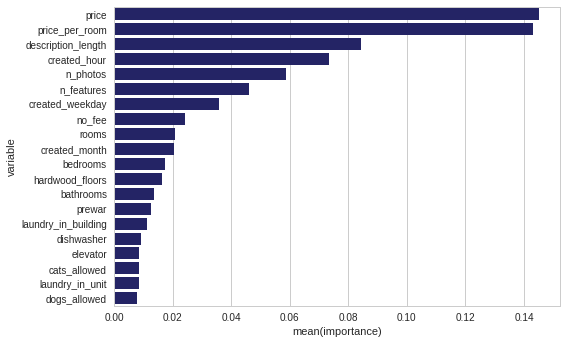

In [12]:
importance = pd.DataFrame({'variable':independent, 'importance':model_rf.feature_importances_})
importance.sort_values(by='importance', ascending=False, inplace=True)
top_importance = importance.head(20)

sns.barplot(y='variable', x='importance', color="midnightblue", data=top_importance)

In [9]:
rental_utils.prepare_submission(model, test, independent)

Written to file Submissions/submission_2017-03-22_1737.csv
   listing_id      high    medium       low
0     7142618  0.069014  0.248938  0.682048
1     7210040  0.103586  0.230697  0.665718
2     7174566  0.027040  0.030589  0.942371
3     7191391  0.128080  0.329540  0.542380
4     7171695  0.034259  0.100720  0.865021


0